1. 跳元模型
    * 1.1 嵌入层
    * 1.2 定义前向传播
2. 训练
    * 2.1. 二元交叉熵损失，比普通的交叉熵损失套了一层sigmoid
    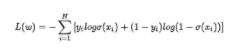
    * 2.2. 初始化模型参数
    * 2.3. 定义训练阶段代码
3. 应用词嵌入
    * 3.1. 利用余弦相似度获取相近词：
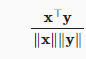
4. 小结

In [35]:
import math
import torch
from torch import nn
import dltools

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = dltools.load_data_ptb(batch_size, max_window_size,num_noise_words)

In [36]:
for batch in data_iter:
    break

In [37]:
batch

(tensor([[5518],
         [1287],
         [1113],
         [1048],
         [3825],
         [2663],
         [   8],
         [   5],
         [ 372],
         [2242],
         [2985],
         [5158],
         [1958],
         [ 661],
         [3090],
         [ 189],
         [1708],
         [3265],
         [3010],
         [ 136],
         [3520],
         [ 874],
         [1932],
         [ 343],
         [1516],
         [6144],
         [4173],
         [1328],
         [4530],
         [ 112],
         [ 344],
         [   6],
         [4783],
         [3430],
         [ 135],
         [5141],
         [1396],
         [2805],
         [1879],
         [3921],
         [  52],
         [3206],
         [ 334],
         [ 878],
         [ 160],
         [  10],
         [ 215],
         [3796],
         [1933],
         [  39],
         [   1],
         [   8],
         [1111],
         [1430],
         [ 295],
         [ 394],
         [ 364],
         [ 231],
         [ 243

In [38]:
# 嵌入层
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, 'f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [8]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-2.6724e-01,  4.4123e-01,  5.5188e-01, -1.6636e-03],
         [ 8.4730e-01,  4.6577e-01,  1.4323e+00, -1.2829e+00],
         [-8.5020e-01, -8.0719e-01, -3.7251e-01, -1.8328e-01]],

        [[ 1.3364e-01, -5.7333e-01,  2.5822e+00,  1.1952e+00],
         [-1.0422e+00,  3.9892e-01, -1.9231e-01, -1.4947e-01],
         [-1.7512e-01, -3.7021e-01,  1.4484e+00, -2.3009e-01]]],
       grad_fn=<EmbeddingBackward0>)

In [39]:
# 前向传播
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [40]:
# 例子
skip_gram(torch.ones((2, 1), dtype=torch.long),torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [41]:
# 定义二元交叉熵损失

class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [10]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [11]:
# 初始化模型参数，定义两个嵌入层
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size))

In [12]:
# 定义训练代码
def train(net, data_iter, lr, num_epochs, device=dltools.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = dltools.Animator(xlabel='epoch', ylabel='loss',xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = dltools.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = dltools.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)/ mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, 'f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.456, 10472.6 tokens/sec on cpu


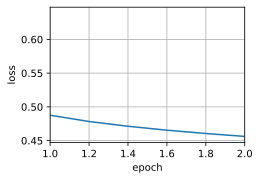

In [43]:
lr, num_epochs = 0.002, 2
train(net, data_iter, lr, num_epochs)

In [42]:
# 词嵌入的应用
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    print(f'W的形状：{W.shape}')
    x = W[vocab[query_token]]
    print(f'x的形状：{x.shape}')
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *torch.sum(x * x) + 1e-9)
    print(f'cos的形状：{cos.shape}')
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32') # 排序选择前K个对应的索引
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('paper', 3, net[0])

W的形状：torch.Size([6719, 100])
x的形状：torch.Size([100])
cos的形状：torch.Size([6719])
cosine sim=0.563: high-grade
cosine sim=0.551: forest-products
cosine sim=0.547: pulp
